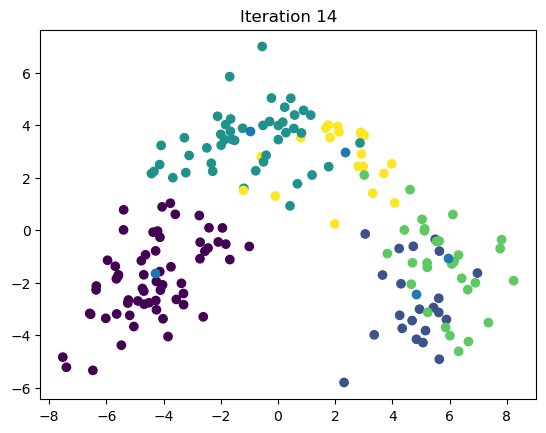

,0,1,2,3,4
alcohol,7.256573,5.996789,3.532286,5.684893,4.042658
malic_acid,3.080322,4.419143,2.754348,6.107691,2.362311
ash,6.172803,6.168006,5.148948,5.973453,4.607840
alcalinity_of_ash,3.867956,6.068076,5.565640,5.754864,4.395549
magnesium,4.545081,4.269127,2.971566,3.175465,3.331160
total_phenols,6.701352,2.939381,5.463233,3.075037,3.278243
flavanoids,5.944719,2.138087,4.644303,1.624562,3.144319
nonflavanoid_phenols,3.520373,4.572466,3.855087,7.384925,6.108722
proanthocyanins,5.158360,3.278436,4.716637,2.725084,2.925520
color_intensity,4.080459,6.475191,2.207876,4.409907,2.438219


In [4]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from IPython.display import clear_output
import random
from sklearn.datasets import load_iris, load_wine

class KMeans:
    def __init__(self, k=5, max_iterations=100):
        self.k = k
        self.max_iterations = max_iterations
        self.centroids = None
        self.labels = None

    def fit(self, data):
        self.centroids = self.random_centroids(data)
        self.labels = self.get_labels(data, self.centroids)
        old_centroids = pd.DataFrame()
        iteration = 1

        while iteration <= self.max_iterations and not self.centroids.equals(old_centroids):
            old_centroids = self.centroids
            self.labels = self.get_labels(data, self.centroids)
            self.centroids = self.new_centroids(data, self.labels)
            self.plot_clusters(data, iteration)  # Plot clusters in each iteration
            iteration += 1

    def predict(self, data):
        return self.get_labels(data, self.centroids)

    def random_centroids(self, data):
        centroids = []
        for i in range(self.k):
            random.seed(42)
            centroid = data.apply(lambda x: float(x.sample().iloc[0]))
            centroids.append(centroid)
        return pd.concat(centroids, axis=1)

    def get_labels(self, data, centroids):
        distances = centroids.apply(lambda x: np.sqrt(((data - x) ** 2).sum(axis=1)))
        return distances.idxmin(axis=1)

    def new_centroids(self, data, labels):
        return data.groupby(labels).apply(lambda x: np.exp(np.log(x).mean())).T

    def plot_clusters(self, data, iteration):
        pca = PCA(n_components=2)
        data_2d = pca.fit_transform(data)
        centroids_2d = pca.transform(self.centroids.T)
        clear_output(wait=True)
        plt.title(f'Iteration {iteration}')
        plt.scatter(x=data_2d[:, 0], y=data_2d[:, 1], c=self.labels)
        plt.scatter(x=centroids_2d[:, 0], y=centroids_2d[:, 1])
        plt.show()


# Load the Iris dataset
# iris = load_iris()
# data = pd.DataFrame(data=iris.data, columns=iris.feature_names)
        
# # Select relevant features for clustering
# features = ["sepal length (cm)", "sepal width (cm)", "petal length (cm)", "petal width (cm)"]
# data = data[features]

wine = load_wine()
data = pd.DataFrame(data=wine.data, columns=wine.feature_names)
# Select relevant features for clustering
features = data.columns.tolist()

# Min-max scaling # data in the range [0-10]
data = (data - data.min()) / (data.max() - data.min()) * 9 + 1

# Create KMeans object
kmeans = KMeans(k=5, max_iterations=100)

# Fit the data
kmeans.fit(data)

# Get labels for prediction
labels = kmeans.predict(data)

# Access centroids
centroids = kmeans.centroids
centroids

In [5]:
from sklearn.cluster import KMeans
kmeans = KMeans(5)
kmeans.fit(data)
pd.DataFrame(kmeans.cluster_centers_, columns=features).T

/Users/dplavos/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,0,1,2,3,4
alcohol,5.276077,7.538134,6.128816,3.880110,4.280672
malic_acid,4.921128,3.118541,5.777470,2.596240,3.966062
ash,6.482256,6.167234,6.069118,5.027111,5.890835
alcalinity_of_ash,6.267573,3.868697,5.900129,5.331695,5.707963
magnesium,5.286561,4.516403,3.479891,3.079373,4.059595
total_phenols,2.785893,6.822633,3.261638,4.153970,6.534839
flavanoids,2.613924,6.069620,1.695411,3.723138,5.463335
nonflavanoid_phenols,2.883362,3.633619,7.287264,5.719175,3.787248
proanthocyanins,3.051907,5.239576,3.166246,3.804783,5.613075
color_intensity,5.274511,4.337093,5.592342,2.299567,2.596210
